# Predicting Property Maintenance Fines (or Blight)

This is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

____
## A Quick Summary
Using Python, the data was imported and then processed using several techniques. For instance:

    Specific features were dropped due to either data leakage or inconsistencies
    Violation address was converted to the respected lat/lon coordinate pairs
    Categorical data was 'one-hot-encoded' with a defined frequency threshold
    Feature engineering was performed on two datetime features by taking the day difference
    Models were trained with the roc_auc scoring, as opposed to just accuracy (allow for skewedness in data!)
    Two classifier algorithms were fitted, Gradient Boosting and Logistic Regression
    'Some' fine tuning was applied to increase the auc score

Gradient Boosting performed the best, with a 'fine-tuned' score on a 5-fold CV of 0.8057 (rounded). To summarize:

    Gradient Boosting Roc_Auc Score = 0.805666
    Logistic Regression Roc_Auc Score = 0.787156
    

# Import the data

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier  #GB algorithm
from sklearn.linear_model import LogisticRegression # LR algorithm
from sklearn.model_selection import cross_val_score, GridSearchCV # Additional scklearn functions
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc # Scoring metrics to be used

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib notebook

After importing the libraries, we can read in the data. Note that the dataframes for address.csv and latlons.csv are merged on the ticket_id with the train dataframe. We will use the lat/lon data as a replacement for the violation street name and street number (note that the violation zip code was dropped from the set as the majority is NaN).

In [2]:
## Read in data
dtypes = {'ticket_issued_date': 'str', 'hearing_date': 'str'} # set known date labels to strings for conversion to dt
parse_dates = ['ticket_issued_date', 'hearing_date'] # create list of date labels

df_train = pd.read_csv('train.csv',encoding = "ISO-8859-1", 
                        dtype = dtypes, parse_dates = parse_dates) # Read in train.csv
df_test = pd.read_csv('test.csv',encoding = "ISO-8859-1", 
                       dtype = dtypes, parse_dates = parse_dates) # Read in test.csv

# Let's import addresses and accompanying lat/lons and merge on address
df_address = pd.read_csv('addresses.csv', encoding = "ISO-8859-1") # Read in addresses.csv (locations of violations in Detroit)
df_latlons = pd.read_csv('latlons.csv', encoding = "ISO-8859-1") # Lat/lons of violation locactions
df_id_latlons = pd.merge(df_address, df_latlons, how='inner', on='address') # Merge the address and lat/lons on ticket_id

# Drop address label now that it's merged
df_id_latlons.drop('address', axis = 1, inplace = True)

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Drop obvious labels
Any labels that appear to cause either data leakage, inconsistency, or have a majoirty of NaN's are removed from the dataset. Furthermore, we will also drop sampels corresponding to a target value of NaN (blight offenders that were found not responsible).

In [3]:
## Drop data labels that should not be used in analysis
#1 Get labels that are inconsistent with test
inconsistent_labels = ['payment_date', 'payment_status', 'collection_status', 
               'compliance_detail', 'balance_due', 'payment_amount']

#2 Get data leakage labels
data_leak_labels = ['violator_name', 'inspector_name']

#3 Get NaN's labels (col's with majority of NaN's)
NaN_labels = (df_train.isnull().sum() / len(df_train)) <= 0.50
maj_NaN_labels = NaN_labels[NaN_labels==False].index.tolist()

#4 Combine labels and drop from train
labels_to_remove = []
labels_to_remove.extend(inconsistent_labels + data_leak_labels + maj_NaN_labels)
df_train.drop(labels_to_remove, axis=1, 
        inplace = True)

#5 Remove NaN's from compliance label (just keep targets)
compliance_to_keep = df_train.compliance.notnull()
df_train = df_train.loc[compliance_to_keep, :]

After performing steps 1-5 above, the labels that remain in the training set are as such:

In [4]:
df_train.columns.tolist()

['ticket_id',
 'agency_name',
 'violation_street_number',
 'violation_street_name',
 'mailing_address_str_number',
 'mailing_address_str_name',
 'city',
 'state',
 'zip_code',
 'country',
 'ticket_issued_date',
 'hearing_date',
 'violation_code',
 'violation_description',
 'disposition',
 'fine_amount',
 'admin_fee',
 'state_fee',
 'late_fee',
 'discount_amount',
 'clean_up_cost',
 'judgment_amount',
 'compliance']

Note that before steps 1-5 were taken, we had:

    ticket_id
    agency_name
    inspector_name
    violator_name
    violation_street_number, violation_street_name, violation_zip_code
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country
    ticket_issued_date 
    hearing_date 
    violation_code, violation_description 
    disposition 
    fine_amount
    admin_fee 
    state_fee 
    late_fee 
    discount_amount
    clean_up_cost
    judgment_amount
    grafitti_status
    payment_amount 
    payment_date
    payment_status
    balance_due
    collection_status
    compliance_detail
 
Moving forward, we now have only 22 labels, as opposed to the original 33 (excluding compliance, our target label). Note that the removal fo the 11 labels was due to the preprocessing of the data in steps 1-5 above.

## Process the data
To begin, we will remove any remaining labels that we do not want to include in the analysis. We chose the mailing location of the violator to not be included:
    
    ['mailing_address_str_number', 'mailing_address_str_name', 
                  'city', 'state', 'zip_code', 'country']

It is possible that this data can indeed have a positive impact of the AUC train score, but it is assumed that this data can vary too greatly in the test set (and future test sets), and thus our model will not be generalized well enough. However, it is worth considering and should be included in the model when feature engineering becomes a must.

Secondly, we will replace the violation street name / number with the corresponding lat/lon and fill the lat/lon NaN's with the most frequent value.

Third, we'll splice out the columns that are purely objects, and call our own Categories function to convert said columns into categories, specify a frequency threshold, and bucket categories below the threshold as **'unknown'**.

Finally, we'll call get_dummies to complete our one-hot-encoding process of the object data. Note that each label was carefully examined to ensure that one-hot-encoding was the best approach to categorize the data. We noted that each object label were strings that were *not sorted*. If any object was indeed a sorted label (e.g. (low, medium, high), then we would have simply called the method cat.codes and not the function get_dummies.

In [5]:
## Process data
#1 Drop remaining address columns
labels_address = ['mailing_address_str_number', 'mailing_address_str_name', 
                  'city', 'state', 'zip_code', 'country']
df_train.drop(labels_address, axis = 1, 
        inplace = True)

#2 Let's merge violation street name / number with corresponding lat/lons
# and fill na's with most frequent of each column
df_id_latlons = df_id_latlons.apply(lambda x:x.fillna(x.value_counts().index[0]))
df_train = pd.merge(df_train, df_id_latlons, how='inner', on='ticket_id')
df_train.drop(['violation_street_number', 'violation_street_name'], axis = 1, 
              inplace = True)

#3 Get labels of objects for one-hot encoding
col_obj = df_train.dtypes[df_train.dtypes == 'object'].index.tolist()

# Convert object data into categories (fill less than threshold with 'unknown' cat)
def Categories(series):
    threshold = 100 # frequency of categories
    unknown_cat = '<unknown>' # name of additional 'unknown' category
    for series in series:
        count = df_train[series].value_counts()
        categories_to_keep = count[count > threshold].index.tolist()
        df_train[series] = pd.Categorical(df_train[series], 
                categories = categories_to_keep, ordered=True)
        df_train[series] = df_train[series].cat.add_categories(unknown_cat).fillna(unknown_cat)

Categories(col_obj) # Update dataframe with categorical data

#4 Call get_dummies
df_train = pd.get_dummies(df_train, columns = col_obj) # One hot encoding

It's worth noting here that the threshold of categorical frequency was taken 100. This was a design choice and has obvious consequences on the test score. Simply reducing the threshold to allow for categories that have less than 100 appearances will lead to basically empty feature sets when get_dummies is called. Therefore, this will only add computational time and resources, all for a score that won't see much change. 

However, one must take note on the number of categories present in the feature. If the majority are equal or approximate to the threshold, then the threshold should either not be used at all, or altered. *The idea* is to take the majority of the categories that are in the feature, and bin the remaining categories into one 'unknown' category. 

## Feature Engineering
Next, we will engineer a new feature by taking the difference between ticket_issued_date and the hearing_date. We update the new label with the difference in days. Furthermore, we perform a last check on any columns that contain NaN, and fill those NaN's with the respected mean value of the column.

Note that we find the columns that contain NaN's to speed up the fillna() process (as opposed to calculating the mean for every column). 

In [6]:
## Feature engineering
# Remove the two date labels, and engineer a new feature.
# This feature will simply be the time between the hearing data and the 
# issue ticket date.
col_date = ['hearing_date', 'ticket_issued_date']
df_train['hearing_issued_date_diff'] = (df_train[col_date[0]]
        - df_train[col_date[1]]).dt.days
df_train.drop(col_date, axis=1, 
        inplace = True)

NaN_in_labels = df_train.columns[df_train.isnull().any()].tolist()
df_train.fillna(df_train[NaN_in_labels].mean(), inplace=True)

,ticket_id,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,...,"violation_description_Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, structurally sound or in a sanitary condition to prevent threat to the public health, safety or welfare",violation_description_Failing to secure City or Private solid waste collection containers and services,violation_description_Defective exterior wall(s) one- or two-family dwelling or commercial building,violation_description_<unknown>,disposition_Responsible by Default,disposition_Responsible by Admission,disposition_Responsible by Determination,disposition_Responsible (Fine Waived) by Deter,disposition_<unknown>,hearing_issued_date_diff
0,22056,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,42.390729,...,0,0,0,0,1,0,0,0,0,369.0
1,27586,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,42.326937,...,0,0,0,1,0,0,1,0,0,378.0
2,22046,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,42.145257,...,0,0,0,0,1,0,0,0,0,323.0
3,18738,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.433466,...,0,0,0,1,1,0,0,0,0,253.0
4,18735,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,42.388641,...,0,0,0,1,1,0,0,0,0,251.0
5,18733,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,42.388641,...,0,0,0,1,1,0,0,0,0,251.0
6,28204,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.435773,...,0,0,0,1,1,0,0,0,0,323.0
7,18743,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.395765,...,0,0,0,1,1,0,0,0,0,209.0
8,18741,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.440190,...,0,0,0,1,1,0,0,0,0,201.0
9,18978,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.399222,...,0,0,0,1,1,0,0,0,0,189.0


We can show that there are zero NaN values in our set, and that we are ready to start training.

In [10]:
df_train.isnull().any().any()

False

## Begin training the model
We can define a function that performs the fit, caluclates the accuracy and roc_auc score of the training data alone, and then performs cross-validation on the training set to return the averaged roc_auc score of the left-out data. 

It's a good idea to make note of the accuracy and roc_auc score of the entire training set. 

**Accuracy Score on training set**: This metric is helpful in evaluating just how good the model can predict the label of the postitive class. Of course, this metric alone is not a good indicator of the performance of the model, as this metric assumes that any probability above 0.5 should be labeled the positive class. This alone neglects the possibility for skewedness in the target values, but is useful in evauluating variance/bias. 

**ROC_AUC Score on training set**: Looking at the roc_auc score, in conjunction with accuracy, can help define how well the model is performing. The 'auc score' basically takes into account the skewedness of the data by evaulating over many thresholds (not just 0.5) when classifying the data. The area under the roc curve (roc_auc) is essentually a number that explains how much, over a range of thresholds, does the true positives reflect the false positives. A higher roc_auc means that more of the threshold range corresponds to a high true positive rate. 

** ROC_AUC Score on cross-validation set**: Looking at just the training data is again not a good practice, as one does not know if there is a bias/variance problem of the model. One must analyze the hold-out set from the CV results to ensure that the model is generalizing well enough. 

Of course, using the CV score isn't enough either, as we'll have to ensure that unseen, 'new' data still generalizes well to the model (i.e. test.csv).

In [291]:
def modelCV(alg, dtrain, predictors, performCV=True, cv_folds=5):      
    # Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # Perform cross-validation
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], 
                                                    dtrain[target], 
                                                    cv=cv_folds, 
                                                    scoring='roc_auc')
    
    # Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, 
          dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], 
          dtrain_predprob))
    
    if performCV:
        print("AUC_CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
              % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                 np.max(cv_score)))
        
def plotFeatureImp(alg, predictors):
    #Plot feature importance
    feature = 10
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)[:feature]
    ax = feat_imp.plot(kind = 'barh', title="Feature Importance [Top 10]")
    plt.xlabel('Feature Importance Score')
    plt.box(on=None)
    plt.tight_layout()
    
def plotROCAUC(alg, dtrain):
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    fpr, tpr, _ = roc_curve(dtrain[target], dtrain_predprob)
    roc_auc = roc_auc_score(dtrain[target], dtrain_predprob)
    
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (Binary Classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')

Let's identify our id and target column, get our features that we'd like to include, identify our classifier, fit, then call the modelCV function to give us a modest 'model report'.

### Gradient Boosting Classifier

In [33]:
#Choose all predictors except target & IDcols 
target = 'compliance'
IDcol = 'ticket_id'
predictors = [x for x in df_train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
gbm0.fit(df_train[predictors], df_train[target])

modelCV(gbm0, df_train, predictors)


Model Report
Accuracy : 0.944
AUC Score (Train): 0.819741
AUC_CV Score : Mean - 0.8023197 | Std - 0.02520005 | Min - 0.7763131 | Max - 0.8469616


<IPython.core.display.Javascript object>


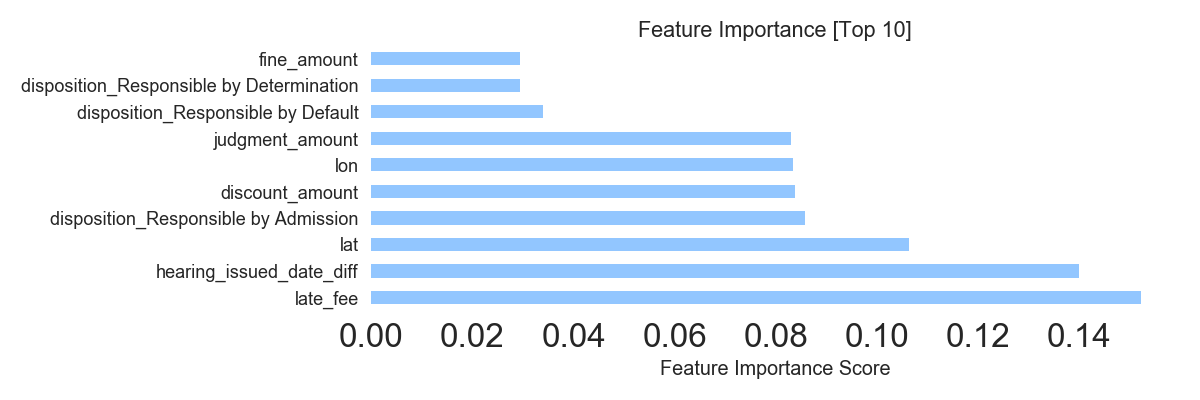

In [292]:
#Plot feature importance
plt.style.use('seaborn-pastel')
plotFeatureImp(gbm0, predictors)

The above score for a default Gradient Boosting Classifier was about 0.8023 (cv mean test score). We can also note the 10 most important features that contributed to the predictions made by the classifier in Figure 1. We can futher optimize and tune the model by performing a grid search over a range of params (GridSearchCV). We perform a grid search and vary the 'n_estimators' parameter for GBC.

In [20]:
param_test1 = {'n_estimators': np.arange(20, 41, 10).tolist()}
gsearch1 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.05,min_samples_split=500,
                                                   min_samples_leaf=50,max_depth=8,
                                                   max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)

gsearch1.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

We can now call the gridsearch object and print the best parameter (in this case, just n_estimator) and the highest mean roc_auc score on the cv test set.

In [21]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 20}, 0.80566598467260619)

Two things to note here. The n_estimators parameter reached the extreme (20) on the range chosen (20, 30, 40). We should increase the lower end of the param range to see if the parameter lies below the current extreme. Also, the test score increased from 0.8023 to 0.8057. Let's continue to optimize by first extending the range for n_estimators. 

In [22]:
param_test1 = {'n_estimators': np.arange(10, 31, 10).tolist()}
gsearch1 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.05,min_samples_split=500,
                                                   min_samples_leaf=50,max_depth=8,
                                                   max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)

gsearch1.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [23]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 20}, 0.80566598467260619)

We can see that lowering the range does not help, as the best value for n_estimators is set at 20. Let's perform another grid search over the follow:

    max_depth [5-15 at int of 2]
    min_samples_split [50-200 at int of 50]
    
We'll make sure to update n_estimators to 20 from the previous gridsearch (gsearch1).

In [192]:
param_test2 = {'max_depth': np.arange(5,11,1).tolist(), 'min_samples_split': np.arange(100,1501,100).tolist()}

gsearch2 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.05, n_estimators=20, 
                                                   max_features='sqrt', subsample=0.8, 
                                                   random_state=10), 
                        param_grid = param_test2, scoring='roc_auc', iid=False, cv=5)

gsearch2.fit(df_train[predictors],df_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 8, 'min_samples_split': 900}, 0.80559233621530102)

We can see that the auc score generated here is lower than the previous. It however can be assumed that gridsearching over other parameters besides 'max_depth' and 'min_samples_split' will lead to a higher score. Increasing the number of trees ('n_estimators') and lowering the 'learning_rate' can lead to significant gains in score. 

Once the fine tuning is complete, the results can be analyed against the unseen test set. The test set will have to be processed in the same manner as the training set. One must be careful not to remove samples from the test set when dealing with NaN's, as samples of a test set should be treated as real world samples that hold significance. Of course, we're expecing the test score to be slightly below the finalized cv score. 

Let's run our 'final' model of gradient boosting with:

    n_estimators: 20
    min_samples_split: 500
    max_depth: 8
    
Then, let's plot our feature importances.


Model Report
Accuracy : 0.9362
AUC Score (Train): 0.815307
AUC_CV Score : Mean - 0.805666 | Std - 0.02358854 | Min - 0.7823296 | Max - 0.8497655


<IPython.core.display.Javascript object>


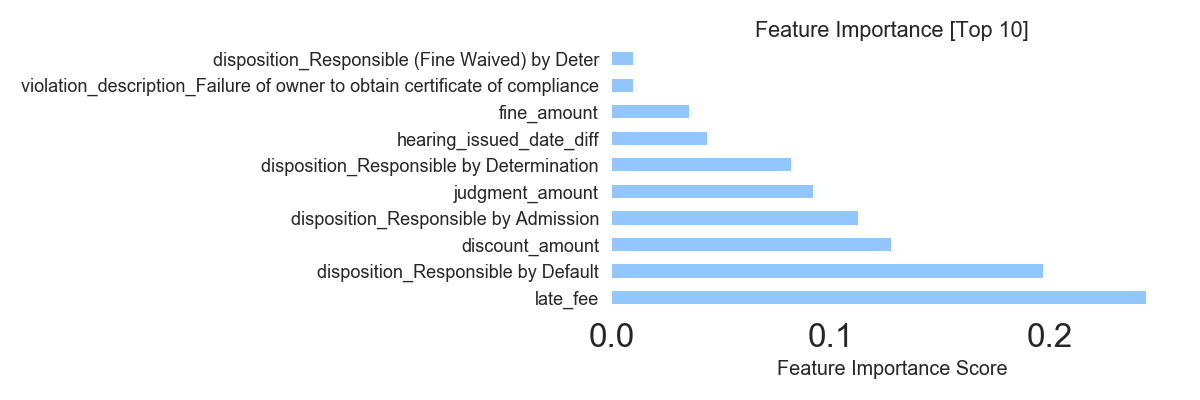

In [300]:
gbm2 = GradientBoostingClassifier(learning_rate=0.05,n_estimators = 20, 
                                               min_samples_split=500, min_samples_leaf=50,
                                               max_depth=8, max_features='sqrt',
                                               subsample=0.8, random_state=10)

gbm2.fit(df_train[predictors], df_train[target])
modelCV(gbm2, df_train, predictors)
#Plot feature importance
plt.style.use('seaborn-pastel')
plotFeatureImp(gbm2, predictors)

One can note that the feature late_fee is still the most important, followed by several categories for the original 'disposition' feature.

### Logistic Regression
Let's model using logistic regression. We're expecting quicker results, but not as much accuracy as we'd like. Furthermore, we're going to only transform the data once for scaling purposes (note that this should be done in a pipeline with each change in cv fold). 

In [185]:
lr0 = LogisticRegression(random_state=10)

# Scale the data from 0 to 1.0
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train) # transform df_train values. Result is array
df_train_scaled = pd.DataFrame(train_scaled, columns=df_train.columns) # put back into df with correct columns

# Now fit the data
lr0.fit(df_train_scaled[predictors], df_train_scaled[target])

modelCV(lr0, df_train_scaled, predictors)


Model Report
Accuracy : 0.9326
AUC Score (Train): 0.794789
AUC_CV Score : Mean - 0.7855392 | Std - 0.02741742 | Min - 0.7552199 | Max - 0.8372791


Running a logistic regression classifier with the default params, we can obtain a cv auc_score of 0.7855. This is lower than the first go-around with GBC (0.8023). Also, the accuracy of 0.9326 is slightly lower than GBC's to 0.9440. Unlike GBC, we can adjust the regularization parameter and see what we can produce.

In [189]:
param_test1 = {'C': np.arange(30,201,10).tolist()}
lrsearch1 = GridSearchCV(LogisticRegression(random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',
                        iid=False, cv=5)
lrsearch1.fit(df_train_scaled[predictors],df_train_scaled[target])
lrsearch1.best_params_, lrsearch1.best_score_

({'C': 40}, 0.78715651694138755)

We can see that a C value of 40 optimizes the model a little more, with an auc score of 0.7872. For most cases, optimizing C (or trying different penalty scenarios with L1 and L2 against C) is enough for an LR classifier. Note that even after optimizing for regularization, the auc score is still below GBC. We will not continue to optimize this classifier as there was little gain with change in C vs the auc score being produced with GBC.